In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST 
import numpy as np 

In [2]:
dataset=MNIST(root="C:" , download=True)

In [3]:
len(dataset)

60000

In [4]:
test_dataset=MNIST(root="C:",train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x22EB0375990>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


lable: 5


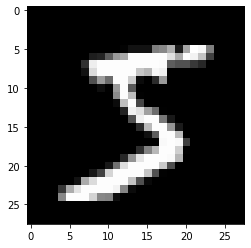

In [7]:
img,lab=dataset[0]
plt.imshow(img,cmap="gray")
print("lable:",lab)


lable:

 4


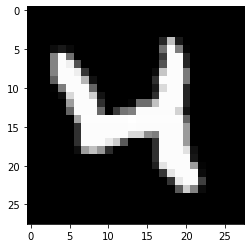

In [8]:
img,lab=dataset[20]
plt.imshow(img,cmap="gray")
print("lable:",lab)


In [9]:
import torchvision.transforms as transforms

In [10]:
dataset=MNIST(root="C:",train=True,transform=transforms.ToTensor())

In [11]:
img_tensors,lab=dataset[0]
print(img_tensors.shape)

torch.Size([1, 28, 28])


In [12]:
print(img_tensors[:,5:15,5:20])
print(torch.max(img_tensors),torch.min(img_tensors))

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
          0.0706, 0.0706, 0.0706, 0.4941, 0.5333, 0.6863, 0.1020],
         [0.0000, 0.0000, 0.0000, 0.1176, 0.1412, 0.3686, 0.6039, 0.6667,
          0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.8824, 0.6745],
         [0.0000, 0.0000, 0.1922, 0.9333, 0.9922, 0.9922, 0.9922, 0.9922,
          0.9922, 0.9922, 0.9922, 0.9922, 0.9843, 0.3647, 0.3216],
         [0.0000, 0.0000, 0.0706, 0.8588, 0.9922, 0.9922, 0.9922, 0.9922,
          0.9922, 0.7765, 0.7137, 0.9686, 0.9451, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.3137, 0.6118, 0.4196, 0.9922, 0.9922,
          0.8039, 0.0431, 0.0000, 0.1686, 0.6039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.0039, 0.6039, 0.9922,
          0.3529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5451, 0.9922,
          0.7451, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0

torch.Size([28, 28])

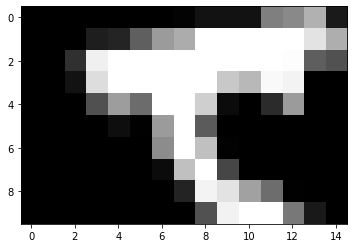

In [13]:
plt.imshow(img_tensors[0,5:15,5:20],cmap="gray")
img_tensors[0,:,:].shape

In [14]:
from torch.utils.data import random_split

In [15]:
train_ds,val_ds=random_split(dataset,[50000,10000])
print(len(train_ds),len(val_ds))

50000 10000


In [16]:
from torch.utils.data import DataLoader

batch_size=128

train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size)

2
2
2
2
2


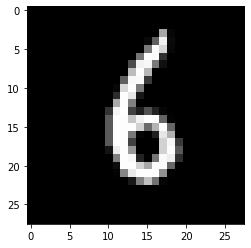

In [17]:
c=0
for i,j in train_loader:
    print(i[0,0,:].ndim)
    plt.imshow(i[0,0,:],cmap="gray")
    c=c+1
    if c==5:
        break

3
3
3
3
3


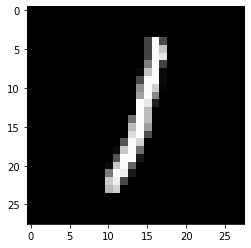

In [18]:
c=0
for i,j in train_loader:
    print(np.transpose(i[0].numpy(),(1,2,0)).ndim)
    plt.imshow(np.transpose(i[0].numpy(),(1,2,0)),cmap="gray")
    c=c+1
    if c==5:
        break

torch.Size([128, 1, 28, 28])
3
torch.Size([128, 1, 28, 28])
3
torch.Size([128, 1, 28, 28])
3
torch.Size([128, 1, 28, 28])
3
torch.Size([128, 1, 28, 28])
3


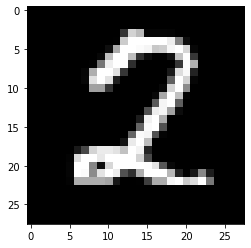

In [19]:
c=0
for i,j in train_loader:
    print(i.shape)
    print(np.transpose(i[0].numpy(),(1,2,0)).ndim)
    plt.imshow(torch.permute(i[0],(1,2,0)),cmap="gray")
    c=c+1
    if c==5:
        break

In [20]:
import torch.nn as nn 
import torch.nn.functional as f
model=nn.Linear(28*28,10)

In [21]:
print(model.weight.shape)
print(model.bias.shape)

torch.Size([10, 784])
torch.Size([10])


In [22]:
def accuracy(out,lab):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds==lab).item()/len(preds))
lab

5

In [23]:
def evaluate(model,val_loader):
    e=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(e)

In [24]:
class ministmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(28*28,10)
    def forward(self,x):
        x=x.reshape(-1,28*28)
        return self.linear(x)
    
    def training_step(self,batch):
        images,lables=batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        return loss
    
    def validation_step(self,batch):
        images, lables =batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        acc=accuracy(out,lables)
        return {"val_loss":loss,"val_acc":acc}
    
    def validation_epoch_end(self,out):
        batch_loss=[x["val_loss"] for x in out]
        batch_acc=[x["val_acc"] for x in out]
        epoch_loss=torch.stack(batch_loss).mean()
        epoch_acc=torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch[{}] ,val_loss:{:.4f},val_acc:{:.4f} ".format(epoch,result["val_loss"],result["val_acc"]))
        



model=ministmodel()

In [25]:
def fit(epochs,model,lr,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer=opt_func(model.parameters(),lr)
    history=[]

    for epoch in range(epochs):
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        res=evaluate(model,val_loader)
        model.epoch_end(epoch,res)
        history.append(res)
    return history

In [26]:
history1=fit(6,model,0.5,train_loader,val_loader)

Epoch[0] ,val_loss:0.3201,val_acc:0.9078 
Epoch[1] ,val_loss:0.3049,val_acc:0.9128 
Epoch[2] ,val_loss:0.3049,val_acc:0.9140 
Epoch[3] ,val_loss:0.2823,val_acc:0.9201 
Epoch[4] ,val_loss:0.2809,val_acc:0.9201 
Epoch[5] ,val_loss:0.2872,val_acc:0.9196 


In [27]:
history2=fit(6,model,0.001,train_loader,val_loader)

Epoch[0] ,val_loss:0.2823,val_acc:0.9210 
Epoch[1] ,val_loss:0.2799,val_acc:0.9211 
Epoch[2] ,val_loss:0.2787,val_acc:0.9215 
Epoch[3] ,val_loss:0.2780,val_acc:0.9209 
Epoch[4] ,val_loss:0.2776,val_acc:0.9209 
Epoch[5] ,val_loss:0.2773,val_acc:0.9209 


In [28]:
history3=fit(6,model,0.001,train_loader,val_loader)

Epoch[0] ,val_loss:0.2771,val_acc:0.9205 
Epoch[1] ,val_loss:0.2769,val_acc:0.9203 
Epoch[2] ,val_loss:0.2767,val_acc:0.9213 
Epoch[3] ,val_loss:0.2765,val_acc:0.9213 
Epoch[4] ,val_loss:0.2764,val_acc:0.9212 
Epoch[5] ,val_loss:0.2763,val_acc:0.9213 


In [29]:
history4=fit(6,model,0.001,train_loader,val_loader)

Epoch[0] ,val_loss:0.2762,val_acc:0.9212 
Epoch[1] ,val_loss:0.2761,val_acc:0.9213 
Epoch[2] ,val_loss:0.2760,val_acc:0.9214 
Epoch[3] ,val_loss:0.2759,val_acc:0.9214 
Epoch[4] ,val_loss:0.2758,val_acc:0.9215 
Epoch[5] ,val_loss:0.2757,val_acc:0.9215 


In [30]:
history4=fit(6,model,0.001,train_loader,val_loader)

Epoch[0] ,val_loss:0.2757,val_acc:0.9215 
Epoch[1] ,val_loss:0.2756,val_acc:0.9215 
Epoch[2] ,val_loss:0.2755,val_acc:0.9214 
Epoch[3] ,val_loss:0.2755,val_acc:0.9212 
Epoch[4] ,val_loss:0.2754,val_acc:0.9212 
Epoch[5] ,val_loss:0.2754,val_acc:0.9212 


In [31]:
history4=fit(6,model,0.001,train_loader,val_loader)

Epoch[0] ,val_loss:0.2753,val_acc:0.9212 
Epoch[1] ,val_loss:0.2753,val_acc:0.9212 
Epoch[2] ,val_loss:0.2752,val_acc:0.9211 
Epoch[3] ,val_loss:0.2752,val_acc:0.9213 
Epoch[4] ,val_loss:0.2751,val_acc:0.9213 
Epoch[5] ,val_loss:0.2751,val_acc:0.9213 


In [32]:
test=MNIST(root="C:",train=False,transform=transforms.ToTensor())


In [33]:
def predict(image,lable):
    x=image.unsqueeze(0)
    x=model.forward(x)
    _,preds=torch.max(x,dim=1)
    return preds[0].item()


preddicted: 7 Label: 7


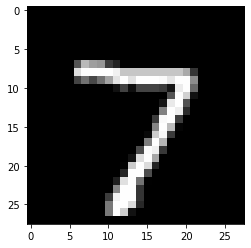

In [34]:
img,lab=test[0]
plt.imshow(img[0],cmap="gray")
print("preddicted:",predict(img,lab),"Label:",lab)

preddicted:

 0 Label: 0


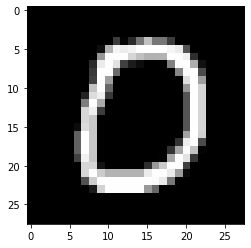

In [35]:
img,lab=test[10]
plt.imshow(img[0],cmap="gray")
print("preddicted:",predict(img,lab),"Label:",lab)

preddicted: 3 Label: 9


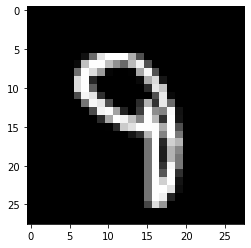

In [36]:
img,lab=test[193]
plt.imshow(img[0],cmap="gray")
print("preddicted:",predict(img,lab),"Label:",lab)

preddicted: 2 Label: 2


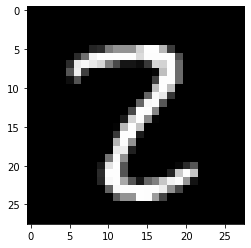

In [37]:
img,lab=test[1839]
plt.imshow(img[0],cmap="gray")
print("preddicted:",predict(img,lab),"Label:",lab)

In [38]:
torch.save(model.state_dict(),"Working with MNIST(Linear relations).pth")

In [39]:
model2=ministmodel()
model2.load_state_dict(torch.load("Working with MNIST(Linear relations).pth"))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0341, -0.0171,  0.0176,  ...,  0.0315, -0.0075, -0.0333],
                      [-0.0023,  0.0107,  0.0130,  ...,  0.0040, -0.0271, -0.0219],
                      [ 0.0159, -0.0187,  0.0237,  ...,  0.0011, -0.0180, -0.0185],
                      ...,
                      [-0.0235, -0.0333,  0.0272,  ..., -0.0324,  0.0252,  0.0311],
                      [ 0.0194,  0.0321,  0.0290,  ...,  0.0106, -0.0322,  0.0269],
                      [-0.0281, -0.0090,  0.0078,  ...,  0.0120,  0.0047,  0.0343]])),
             ('linear.bias',
              tensor([-0.6224,  0.4558,  0.2194, -0.4002, -0.0219,  1.7986, -0.1414,  0.9090,
                      -1.8641, -0.3708]))])